In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up the environement of the notebook

In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load and visualize the data

In [5]:
x_train_val = np.load('/content/drive/MyDrive/Colab Notebooks/A2NDL/P2/x_train.npy')
y_train_val = np.load('/content/drive/MyDrive/Colab Notebooks/A2NDL/P2/y_train.npy')

In [6]:
labels={0: "Wish",
1: "Another",
2: "Comfortably",
3: "Money",
4: "Breathe",
5: "Time",
6: "Brain",
7: "Echoes",
8: "Wearing",
9: "Sorrow",
10: "Hey",
11: "Shine"}

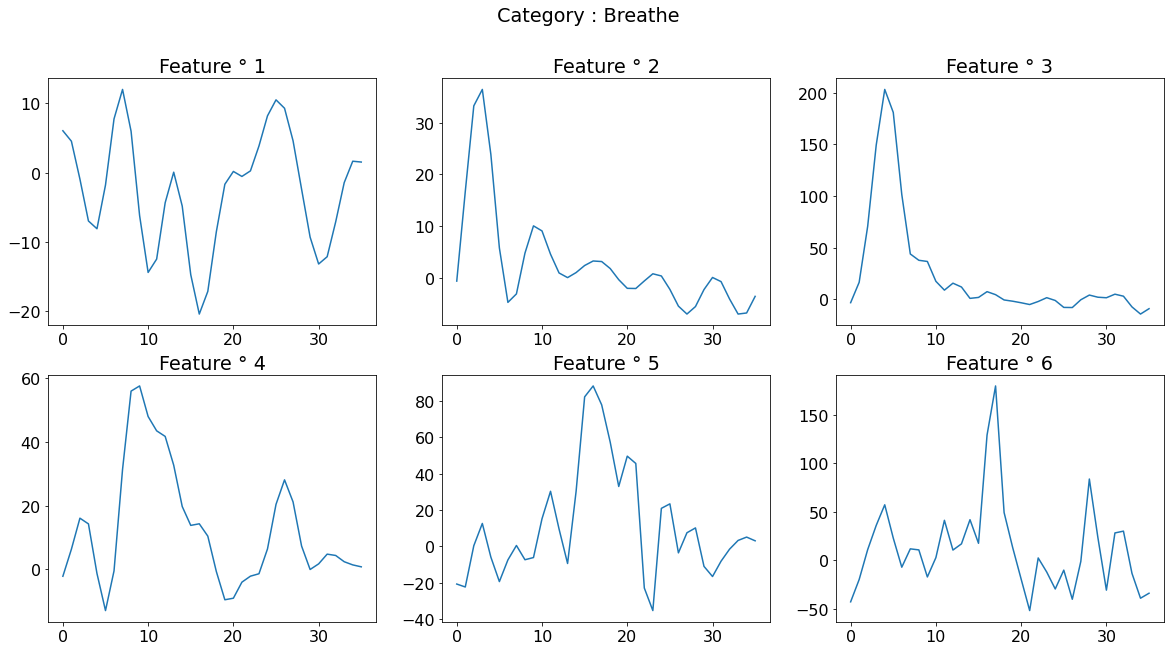

In [7]:
def plot_example(random_index, x,y ):
    example=x[random_index]
    example_label=y[random_index]

    n_points=example.shape[0] # 36
    n_features=example.shape[1] # 6

    counter=0
    fig, axs= plt.subplots(2, 3, figsize=(20,10))
    fig.suptitle('Category : '+labels[example_label])
    for i in range(n_features):
        row= counter//3
        col= counter%3
        example_on_ith_feature=example[:,i]
        axs[row,col].set_title('Feature ° '+str(i+1))
        axs[row,col].plot(example_on_ith_feature)
        counter=counter+1

random_index=np.random.randint(0,2428) 
plot_example(random_index,x_train_val,y_train_val)

In [8]:
# CLASS REPARTITIONS

class_repartitions={"Wish":0,
"Another":0,
"Comfortably":0,
"Money":0,
"Breathe":0,
"Time":0,
"Brain":0,
"Echoes":0,
"Wearing":0,
"Sorrow":0,
"Hey":0,
"Shine":0}

for y in y_train_val:
    label=labels[y]
    class_repartitions[label]=class_repartitions[label]+1
    
S=0
for key in class_repartitions:
    S=S+class_repartitions[key]

print("TOTAL : ",S)
print(class_repartitions)

TOTAL :  2429
{'Wish': 34, 'Another': 123, 'Comfortably': 270, 'Money': 381, 'Breathe': 62, 'Time': 153, 'Brain': 313, 'Echoes': 68, 'Wearing': 120, 'Sorrow': 777, 'Hey': 77, 'Shine': 51}


# Preprocess the data

- Scaling the data

In [9]:
from sklearn.preprocessing import RobustScaler

x_train_scale = np.copy(x_train_val)

for i in range(x_train_val.shape[2]):
  transformer = RobustScaler().fit(x_train_val[:,:,i])
  x_train_scale[:,:,i] = transformer.transform(x_train_val[:,:,i])

- Data Augmentation

In [10]:
def jitter(x):
  return x + np.random.normal(loc=0., scale=0.9, size=x.shape)

def permutation(x, max_segments, seg_mode="equal"):
  orig_steps = np.arange(x.shape[1])
  
  num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
  ret = np.zeros_like(x)
  for i, pat in enumerate(x):
      if num_segs[i] > 1:
          if seg_mode == "random":
              split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
              split_points.sort()
              splits = np.split(orig_steps, split_points)
          else:
              splits = np.array_split(orig_steps, num_segs[i])
          warp = np.concatenate(np.random.permutation(splits)).ravel()
          ret[i] = pat[warp]
      else:
          ret[i] = pat
  return ret

def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

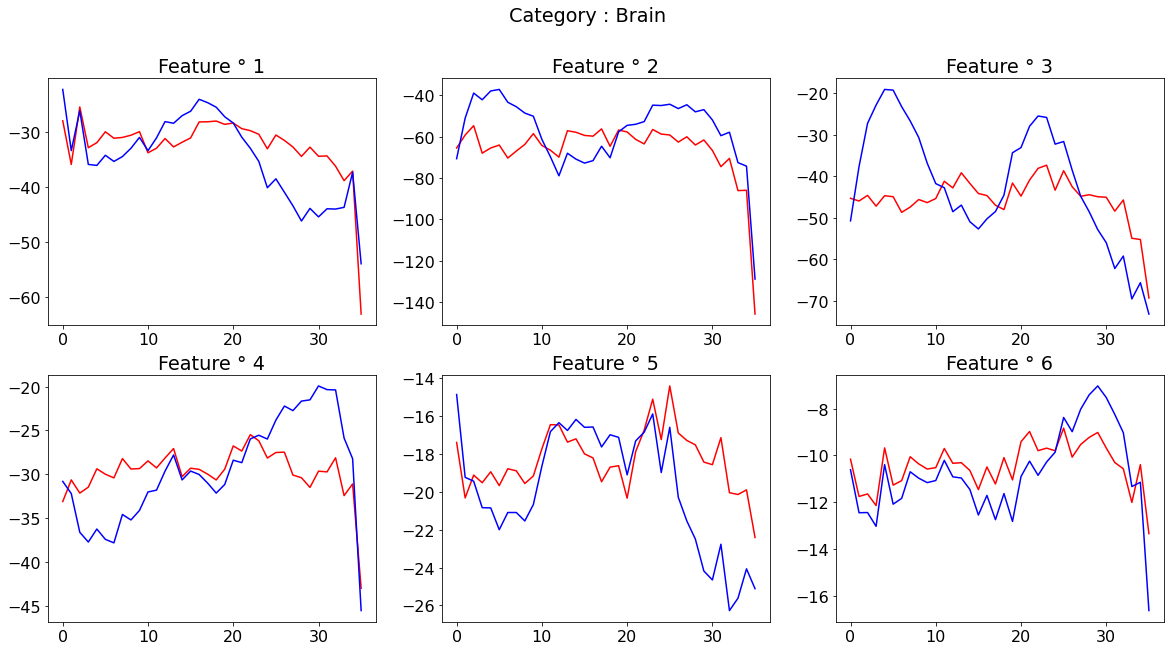

In [11]:
def plot_example_aug(random_index, x, x_aug, y):
    example=x[random_index]
    example_aug=x_aug[random_index]
    example_label=y[random_index]

    n_points=example.shape[0] # 36
    n_features=example.shape[1] # 6

    counter=0
    fig, axs= plt.subplots(2, 3, figsize=(20,10))
    fig.suptitle('Category : '+labels[example_label])
    for i in range(n_features):
        row= counter//3
        col= counter%3
        example_on_ith_feature=example[:,i]
        example_on_ith_feature_aug=example_aug[:,i]
        axs[row,col].set_title('Feature ° '+str(i+1))
        axs[row,col].plot(example_on_ith_feature, color='r', label='normal')
        axs[row,col].plot(example_on_ith_feature_aug, color='b', label='augmentation')
        counter=counter+1

random_index=np.random.randint(0,2428) 
x_train_scale_permut = permutation(x_train_scale, 5)
#x_train_scale_timewarp = time_warp(x_train_scale)
#x_train_scale_reverse = x_train_scale.reverse()
#x_train_scale_rotation = rotation(x_train_scale)
x_train_scale_magnwrap = magnitude_warp(x_train_scale)
plot_example_aug(random_index,
                 x_train_scale, 
                 x_train_scale_magnwrap, #augmented data to compare with the original
                 y_train_val)


# Model and training

In [12]:
# SPLITING
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train_scale, y_train_val, test_size=0.25, random_state=seed, stratify=y_train_val)

TOTAL :  7284


<BarContainer object of 12 artists>

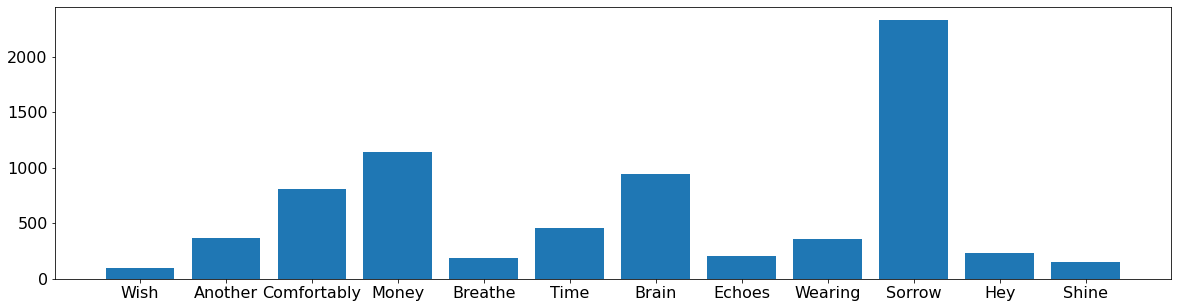

In [144]:
from tensorflow.python.ops.math_ops import Max
# Adding data augmentation on x_train to unbalance the dataset 

def augmented_dataV1(x, y):
  new_x = np.copy(x)
  new_y = np.copy(y)

  for j in range(5):
    df_y = pd.DataFrame(new_y, columns=['y'])
    distribution = df_y.groupby(new_y).count()
    for i in range(distribution.shape[0]):
      if (distribution.y[i]*2 < max(distribution.y)) :
        #we search the index of the data that we want to augment
        index = [
          index for index in range(len(y))
          if y[index]==i
        ]
        #now we want to extract only the x_train of the index selectioned
        x_i = np.copy(x[index,:,:])
        y_i = np.copy(y[index])

        #now we augment the data
        x_perm = permutation(x_i, 5)
        x_i_perm_tw = time_warp(permutation(x_i, 5))
        
        #now we concatenate the old and the new augmented data
        new_x = np.concatenate((new_x, x_perm), axis=0)
        new_y = np.concatenate((new_y, y_i), axis=0)

  x_perm_tw = time_warp(permutation(new_x,5))
  x_perm_mw = magnitude_warp(permutation(new_x,5))
  new_x = np.concatenate((new_x, x_perm_tw, x_perm_mw), axis=0)
  new_y = np.concatenate((new_y, new_y, new_y), axis=0)

  return new_x, new_y

def augmented_dataV2(x,y):
  new_x = np.copy(x)
  new_y = np.copy(y)

  #permutation
  x_permuted = permutation(x, 5)
  new_x = np.concatenate((new_x, x_permuted), axis=0)
  new_y = np.concatenate((new_y, y), axis=0)

  #time warp X permutation
  x_tw = time_warp(x)
  new_x = np.concatenate((new_x, x_tw), axis=0)
  new_y = np.concatenate((new_y, y), axis=0)

  #magnitude warp X permutation
  x_mw = magnitude_warp(x, 5)
  new_x = np.concatenate((new_x, x_mw), axis=0)
  new_y = np.concatenate((new_y, y), axis=0)

  return new_x, new_y

x_train_aug, y_train_aug = augmented_dataV2(x_train, y_train)

class_repartitions={"Wish":0,"Another":0,"Comfortably":0,"Money":0,"Breathe":0,"Time":0,"Brain":0,"Echoes":0,"Wearing":0,"Sorrow":0,"Hey":0,"Shine":0}
for y in y_train_aug:
    label=labels[y]
    class_repartitions[label]=class_repartitions[label]+1
    
print("TOTAL : ",sum(class_repartitions.values()))
plt.figure(figsize=(20,5))
plt.bar(class_repartitions.keys(), class_repartitions.values())

In [145]:
# Encoding target variable
y_train_categorical = tfk.utils.to_categorical(y_train_aug)
y_val_categorical = tfk.utils.to_categorical(y_val)

In [146]:
x_train_aug.shape, x_val.shape, y_train_categorical.shape, y_val_categorical.shape

((7284, 36, 6), (608, 36, 6), (7284, 12), (608, 12))

In [147]:
#input_shape = x_train.shape[1:]
input_shape = x_train_aug.shape[1:]
output_shape = y_train_categorical.shape[1:]
batch_size = 128
epochs = 1000

In [148]:
def build_1DCNN_classifier(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout1 = tfkl.Dropout(0.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout1)
    dropout2 = tfkl.Dropout(0.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(output_shape[0], activation='softmax')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [149]:
model = build_1DCNN_classifier(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_30 (Conv1D)          (None, 36, 256)           4864      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 18, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 18, 256)           196864    
                                                                 
 global_average_pooling1d_15  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_30 (Dropout)        (None, 256)               0     

In [151]:
# Train the model
history = model.fit(
    x = x_train_aug,
    y = y_train_categorical,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val_categorical),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=45, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-5)
    ]   
).history

Epoch 1/1000
57/57 [==============================] - 1s 18ms/step - loss: 5.2263 - accuracy: 0.1919 - val_loss: 2.3090 - val_accuracy: 0.3503 - lr: 0.0010
Epoch 2/1000
57/57 [==============================] - 0s 8ms/step - loss: 2.7768 - accuracy: 0.3326 - val_loss: 2.1660 - val_accuracy: 0.3553 - lr: 0.0010
Epoch 3/1000
57/57 [==============================] - 0s 7ms/step - loss: 2.2592 - accuracy: 0.3497 - val_loss: 1.9974 - val_accuracy: 0.3520 - lr: 0.0010
Epoch 4/1000
57/57 [==============================] - 0s 9ms/step - loss: 2.0927 - accuracy: 0.3521 - val_loss: 1.9314 - val_accuracy: 0.3618 - lr: 0.0010
Epoch 5/1000
57/57 [==============================] - 0s 6ms/step - loss: 2.0116 - accuracy: 0.3531 - val_loss: 1.8703 - val_accuracy: 0.3618 - lr: 0.0010
Epoch 6/1000
57/57 [==============================] - 0s 6ms/step - loss: 1.9601 - accuracy: 0.3622 - val_loss: 1.8410 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 7/1000
57/57 [==============================] - 0s 6ms/step - l

In [152]:
predictions = model.predict(x_val)
predictions.shape

19/19 [==============================] - 0s 2ms/step


(608, 12)

Accuracy: 0.7418
Precision: 0.8251
Recall: 0.6167
F1: 0.6605


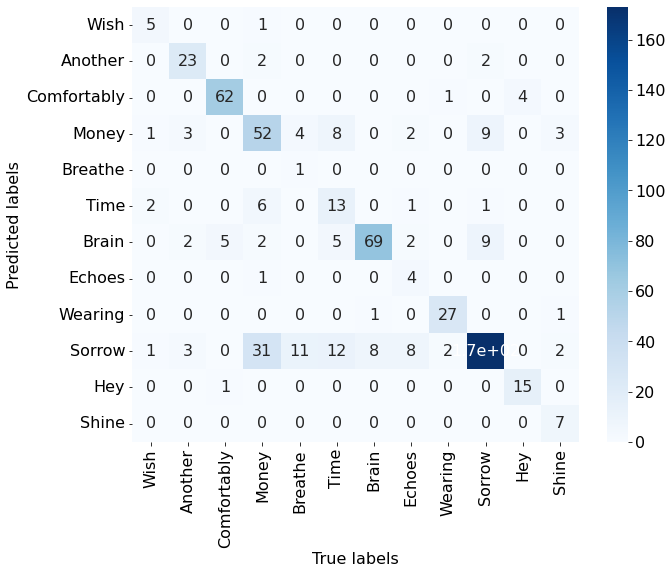

In [153]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(labels.values()), yticklabels=list(labels.values()), annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [109]:
%cd /content/drive/MyDrive/Colab Notebooks/A2NDL/P2
%mkdir -p saved_model
model.save('saved_model/CONV1D_V6')

/content/drive/MyDrive/Colab Notebooks/A2NDL/P2
